In [255]:
import seaborn as sns
import statsmodels as sts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import mord as m

In [256]:
df = pd.read_csv("csv_files\cricket_flour_second_stage.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\VOrozco\AppData\Local\Temp\ipykernel_62680\1461466593.py:1: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("csv_files\cricket_flour_second_stage.csv")


,buying_intention,click,health_conscious,sustainability,prior_exposure,cooking_frequency,age,gender,location,group
0,3,Yes,3,5,No,2,25-34,Female,Czech Republic,control
1,3,Yes,2,4,No,2,44-above,Female,France,health_social
2,6,Yes,2,2,Yes,3,25-34,Male,Spain,sus_social
3,3,No,2,2,Yes,3,44-above,Female,Greece,health_regular
4,2,Yes,3,4,No,1,25-34,Female,Italy,control


## Ordinal Regression

In [257]:
# Convert variables
# click
df["click"] = df["click"].map({"Yes":1, "No":0})

In [258]:
# convert to dummy variables 
# prior exposure, gender, group,location, age
dummy_vars = pd.get_dummies(
    data= df,
    columns= ["prior_exposure", "gender", "group","location", "age"],
    drop_first= True,
    prefix= ["prior", "", "", "", ""]
).astype(int)


In [259]:
len(dummy_vars)

1000

In [260]:
dummy_vars.columns

Index(['buying_intention', 'click', 'health_conscious', 'sustainability',
       'cooking_frequency', 'prior_Yes', '_Male', '_Non-binary',
       '_health_regular', '_health_social', '_sus_regular', '_sus_social',
       '_Belgium', '_Czech Republic', '_Denmark', '_Finland', '_France',
       '_Germany', '_Greece', '_Hungary', '_Italy', '_Netherlands', '_Norway',
       '_Poland', '_Portugal', '_Spain', '_Sweden', '_Switzerland', '_25-34',
       '_35-44', '_44-above'],
      dtype='object')

In [261]:
# Define predictors (excluding your target)
predictors = ['health_conscious', 'sustainability',
              'cooking_frequency', 'prior_Yes', '_Male', '_Non-binary',
              '_health_regular', '_health_social', '_sus_regular', '_sus_social',
              '_25-34','_35-44', '_44-above']

X = dummy_vars[predictors]
y = dummy_vars['buying_intention']

In [262]:
ordered_model = OrderedModel(y,X)
results_order = ordered_model.fit(model="bfgs")
print(results_order.summary())

c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method nm is: xtol, ftol, maxfun. The list of unsupported keyword arguments passed include: model. After release 0.14, this will raise.
  warnings.warn(
c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,


                             OrderedModel Results                             
Dep. Variable:       buying_intention   Log-Likelihood:                -1376.9
Model:                   OrderedModel   AIC:                             2792.
Method:            Maximum Likelihood   BIC:                             2885.
Date:                Mon, 01 Sep 2025                                         
Time:                        12:01:20                                         
No. Observations:                1000                                         
Df Residuals:                     981                                         
Df Model:                          13                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
health_conscious     -0.0354      0.039     -0.903      0.367      -0.112       0.041
sustainability        0.0670   

c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Thresholds are not incremental probably due to low evident difference across all categories of buying intention, because of this I will reduce the number of categories. This will allow the model to stabilize the estimates. 

In [263]:
df["buying_intention"].value_counts()

buying_intention
3    355
4    310
2    180
5    121
6     27
7      5
1      2
Name: count, dtype: int64

In [264]:
# Collapse buying intention
def mapping(value):
   if value in[1,2,3]:
      return 1
   elif value in [3,4]:
      return 2
   elif value  == 5:
      return 3
   elif value in [6,7]:
      return 4

dummy_vars["buying_intention"] = df["buying_intention"].aggregate(mapping)

C:\Users\VOrozco\AppData\Local\Temp\ipykernel_62680\2555341042.py:12: FutureWarning: using <function mapping at 0x000001C7D8609EE0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  dummy_vars["buying_intention"] = df["buying_intention"].aggregate(mapping)


In [265]:
dummy_vars["buying_intention"].value_counts()

buying_intention
1    537
2    310
3    121
4     32
Name: count, dtype: int64

<Axes: xlabel='buying_intention', ylabel='count'>

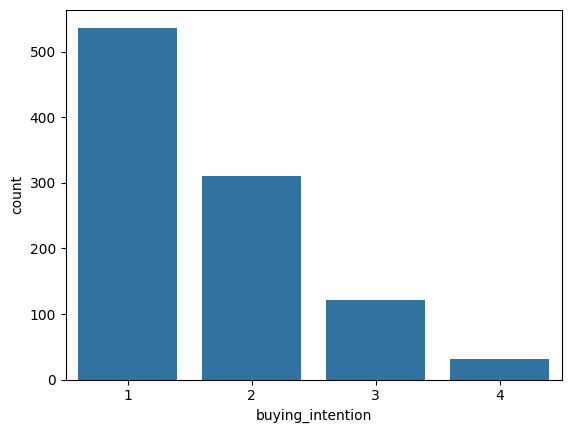

In [266]:
sns.countplot(x = dummy_vars["buying_intention"])

<Axes: xlabel='buying_intention', ylabel='count'>

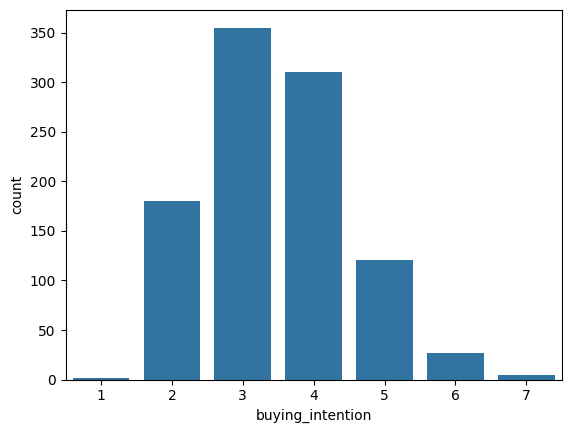

In [267]:
sns.countplot(x = df["buying_intention"])

In [268]:
y = pd.Categorical(dummy_vars["buying_intention"], categories=[1, 2,3,4], ordered=True)


In [269]:
new_ordinal_model = OrderedModel(y,X)
resutls_new_categories = new_ordinal_model.fit()

c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [270]:
print(resutls_new_categories.summary())

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -864.59
Model:                   OrderedModel   AIC:                             1761.
Method:            Maximum Likelihood   BIC:                             1840.
Date:                Mon, 01 Sep 2025                                         
Time:                        12:01:21                                         
No. Observations:                1000                                         
Df Residuals:                     984                                         
Df Model:                          13                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
health_conscious     -0.0815      0.045     -1.800      0.072      -0.170       0.007
sustainability        0.2556   

Still no convergence, so we ran an VIF(Variance inflation Factor) to see if maybe non-convergence is comming from highly correlated columns in X.

In [271]:
# (optional) drop columns with zero variance
nzv = X.columns[X.nunique() <= 1]
X = X.drop(columns=nzv)

# 3) add intercept for VIF calculation (you'll *not* use an intercept in OrderedModel itself)
Xc = add_constant(X, has_constant='add')

# 4) compute VIF
vif = pd.DataFrame({
    "feature": Xc.columns,
    "VIF": [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
}).query("feature != 'const'").sort_values("VIF", ascending=False)

print(vif)


              feature       VIF
11             _25-34  1.759070
12             _35-44  1.652374
8      _health_social  1.626430
13          _44-above  1.618141
9        _sus_regular  1.608641
7     _health_regular  1.596180
10        _sus_social  1.591412
4           prior_Yes  1.026030
5               _Male  1.023951
6         _Non-binary  1.021836
2      sustainability  1.018107
3   cooking_frequency  1.009759
1    health_conscious  1.008770


The difficulty in convergence does not come from the predictors. Because of this we will reduce the classification from 4 to 3, and test.

In [272]:
# Collapse buying intention
def mapping(value):
   if value in[1,2]:
      return 1
   elif value in [3,4]:
      return 2
   elif value in [5,6,7]:
      return 3

dummy_vars["buying_intention"] = df["buying_intention"].aggregate(mapping)

C:\Users\VOrozco\AppData\Local\Temp\ipykernel_62680\4269406159.py:10: FutureWarning: using <function mapping at 0x000001C7CA3B2520> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  dummy_vars["buying_intention"] = df["buying_intention"].aggregate(mapping)


<Axes: xlabel='buying_intention', ylabel='count'>

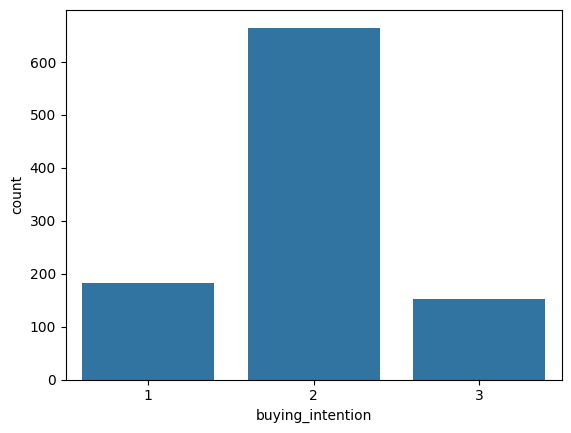

In [273]:
sns.countplot(x=dummy_vars["buying_intention"])


In [274]:
dummy_vars["buying_intention"].value_counts()

buying_intention
2    665
1    182
3    153
Name: count, dtype: int64

In [275]:
y = dummy_vars["buying_intention"]
new_ordinal_model = OrderedModel(y,X)
resutls_new_categories = new_ordinal_model.fit(maxiter= 1000)

c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
c:\Users\VOrozco\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [276]:
print(resutls_new_categories.summary())

                             OrderedModel Results                             
Dep. Variable:       buying_intention   Log-Likelihood:                -662.42
Model:                   OrderedModel   AIC:                             1355.
Method:            Maximum Likelihood   BIC:                             1428.
Date:                Mon, 01 Sep 2025                                         
Time:                        12:01:21                                         
No. Observations:                1000                                         
Df Residuals:                     985                                         
Df Model:                          13                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
health_conscious      0.2841      0.048      5.887      0.000       0.190       0.379
sustainability        0.3258   

Still converges with a warning, possibly because there is class imbalance, so as a next step i will test another model using penalization of class.

In [277]:
y = dummy_vars["buying_intention"].astype(int).values
X_np = np.asarray(X, dtype=float)

# Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X_np)

# Compute class weights to handle imbalance
classes = np.unique(y)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
print(cw)
class_to_w = {c: w for c, w in zip(classes, cw)}
w = np.array([class_to_w[yi] for yi in y])

# Fit a penalized ordinal logistic regression (proportional odds)
model = m.LogisticIT(alpha=3.0)  # alpha = L2 penalty strength
model.fit(X_std, y, sample_weight=w)


[1.83150183 0.50125313 2.17864924]


,alpha,3.0
,verbose,0
,max_iter,1000


In [278]:
def mord_summary(model, feature_names):
    coef = model.coef_.ravel()
    summary_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef
    })
    print("\nModel coefficients:")
    print(summary_df)

    print("\nCutpoints (theta):")
    for i, t in enumerate(model.theta_):
        print(f"  Threshold {i}: {t:.4f}")

mord_summary(model, X.columns)




Model coefficients:
              Feature  Coefficient
0    health_conscious     0.188377
1      sustainability     0.598515
2   cooking_frequency     0.403125
3           prior_Yes     1.718492
4               _Male    -0.233775
5         _Non-binary    -0.071148
6     _health_regular     0.822347
7      _health_social     2.196301
8        _sus_regular     1.248133
9         _sus_social     3.263329
10             _25-34    -0.351550
11             _35-44    -0.515296
12          _44-above    -0.527232

Cutpoints (theta):
  Threshold 0: -2.5453
  Threshold 1: 2.7718


                   ΔP(low)  ΔP(med)  ΔP(high)
feature                                      
_sus_social         -0.002   -0.288     0.290
_health_social      -0.002   -0.258     0.260
prior_Yes           -0.002   -0.231     0.233
cooking_frequency   -0.001   -0.141     0.142
sustainability      -0.001   -0.108     0.109
health_conscious    -0.000   -0.033     0.033
_Non-binary          0.000    0.015    -0.015
_Male                0.001    0.051    -0.052
_25-34               0.001    0.078    -0.079
_35-44               0.001    0.117    -0.119
_44-above            0.001    0.120    -0.122


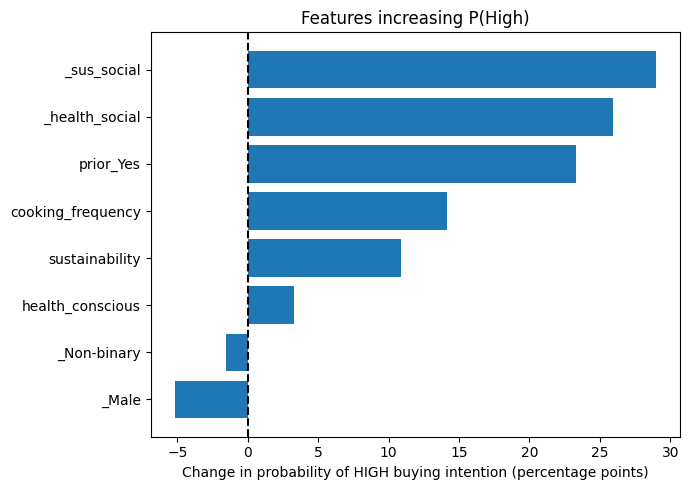

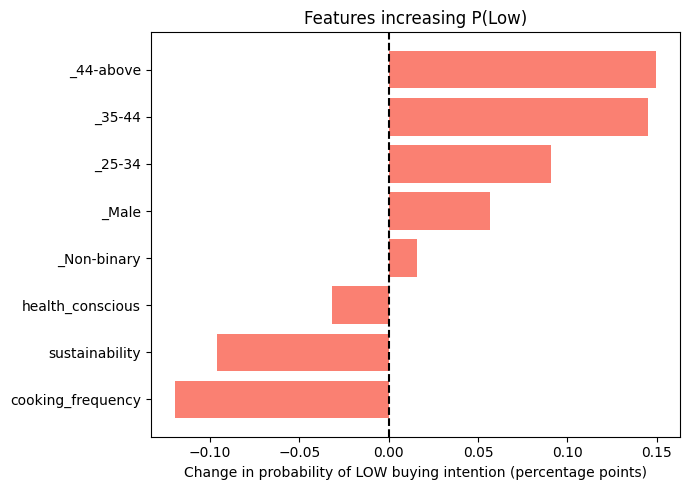

In [279]:
# -------- helpers for mord (works for mord.LogisticIT and similar) --------
def _get_coef_and_thresholds(model):
    # mord stores weights and thresholds under different names across versions
    coef = None
    for name in ["coef_", "w_", "weights_"]:
        if hasattr(model, name):
            coef = np.ravel(getattr(model, name))
            break
    if coef is None:
        raise AttributeError("Could not find coef_/w_/weights_ on the mord model.")
    theta = None
    for name in ["theta_", "threshold_", "cutpoints_"]:
        if hasattr(model, name):
            theta = np.ravel(getattr(model, name))
            break
    if theta is None:
        raise AttributeError("Could not find theta_/threshold_/cutpoints_ on the mord model.")
    return coef, theta

def _probs_from_linear(model, xb):
    """Compute P(low), P(med), P(high) from mord params and xb = x @ beta."""
    coef, theta = _get_coef_and_thresholds(model)
    # theta has J-1 cutpoints; categories assumed ordered [0,1,2]
    sig = lambda z: 1.0 / (1.0 + np.exp(-z))
    cdf = sig(theta - xb)        # shape (J-1,)
    # Probabilities: [cdf1, cdf2-cdf1, 1-cdf2]
    p_low  = cdf[0]
    p_med  = cdf[1] - cdf[0]
    p_high = 1.0 - cdf[1]
    return np.array([p_low, p_med, p_high])

def predict_probs_row(model, x_row):
    """x_row: 1D array-like with same order of features as used in fitting."""
    coef, _ = _get_coef_and_thresholds(model)
    xb = float(np.dot(np.ravel(x_row), coef))
    return _probs_from_linear(model, xb)

# -------- main analysis: feature impacts on probabilities --------
def feature_impacts(model, X: pd.DataFrame, features_to_check=None):
    """
    Compute ΔP(low/med/high) when toggling each feature
    (binary: 0→1; continuous: mean→mean+1SD), holding others at baseline.
    Returns a DataFrame with one row per feature.
    """
    if features_to_check is None:
        features_to_check = list(X.columns)

    # Baseline: zeros for dummies; means for continuous
    baseline = pd.Series(0.0, index=X.columns)
    # treat as continuous if has >2 unique values
    cont_cols = [c for c in X.columns if X[c].nunique() > 2]
    baseline[cont_cols] = X[cont_cols].mean()

    p_base = predict_probs_row(model, baseline.values)

    rows = []
    for feat in features_to_check:
        x0 = baseline.copy()
        x1 = baseline.copy()
        uniq = sorted(X[feat].unique())
        # binary vs continuous toggle
        if set(uniq) <= {0, 1}:
            majority = X[feat].mode()[0]   # most frequent value (0 or 1)
            x0[feat] = majority
            x1[feat] = 1 - majority        # flip it

        else:
            x0[feat] = X[feat].mean()
            x1[feat] = X[feat].mean() + X[feat].std(ddof=0)

        p0 = predict_probs_row(model, x0.values)
        p1 = predict_probs_row(model, x1.values)

        rows.append({
            "feature": feat,
            "ΔP(low)":  p1[0] - p0[0],
            "ΔP(med)":  p1[1] - p0[1],
            "ΔP(high)": p1[2] - p0[2]
        })

    eff = pd.DataFrame(rows).set_index("feature").sort_values("ΔP(high)", ascending=False)
    return eff

  # Top pushers toward HIGH
def plot_impacts(effects: pd.DataFrame, top_n):
    
    """Two bar charts: which features push HIGH up, and which push LOW up (in % points)."""
    eff = effects.copy()
   # Convert to percentage points
    eff = eff * 100  
    top_high = eff.sort_values("ΔP(high)", ascending=False).head(top_n)
    plt.figure(figsize=(7, 5))
    plt.barh(top_high.index[::-1], top_high["ΔP(high)"][::-1])
    plt.axvline(0, linestyle="--", color="k")
    plt.title("Features increasing P(High)")
    plt.xlabel("Change in probability of HIGH buying intention (percentage points)")
    plt.tight_layout()
    plt.show()

    # Top pushers toward LOW
    top_low = eff.sort_values("ΔP(low)", ascending=False).head(top_n)
    plt.figure(figsize=(7, 5))
    plt.barh(top_low.index[::-1], top_low["ΔP(low)"][::-1], color="salmon")
    plt.axvline(0, linestyle="--", color="k")
    plt.title("Features increasing P(Low)")
    plt.xlabel("Change in probability of LOW buying intention (percentage points)")
    plt.tight_layout()
    plt.show()

# -------- usage --------
 
# Choose which features to inspect (or leave None to use all)
features_to_check = ["prior_Yes", "health_conscious", "sustainability","cooking_frequency",
                      "_health_social", "_sus_social", "_Male","_Non-binary","_25-34", "_35-44", "_44-above"]

eff = feature_impacts(model, X, features_to_check)
print(eff.round(3))
plot_impacts(eff, top_n=8)


In [280]:
# --- 1. Baseline as most common profile ---
baseline = pd.Series(index=X.columns, dtype=float)

for col in X.columns:
    # If binary/dummy (0/1): use the most frequent value
    if set(X[col].unique()) <= {0,1}:
        baseline[col] = X[col].mode()[0]
    else:
        # If continuous: use the mean
        baseline[col] = X[col].mean()

print("Baseline profile (most common respondent):")
print(baseline)


Baseline profile (most common respondent):
health_conscious     2.674
sustainability       3.062
cooking_frequency    3.107
prior_Yes            0.000
_Male                0.000
_Non-binary          0.000
_health_regular      0.000
_health_social       0.000
_sus_regular         0.000
_sus_social          0.000
_25-34               0.000
_35-44               0.000
_44-above            0.000
dtype: float64


In [291]:
df["cooking_frequency"].value_counts()

cooking_frequency
2    198
1    182
3    181
4    128
5     92
7     90
0     65
6     64
Name: count, dtype: int64

In [292]:
alt = baseline.copy()
alt["cooking_frequency"] = 6


In [293]:
alt

health_conscious     2.674
sustainability       3.062
cooking_frequency    6.000
prior_Yes            0.000
_Male                0.000
_Non-binary          0.000
_health_regular      0.000
_health_social       0.000
_sus_regular         0.000
_sus_social          0.000
_25-34               0.000
_35-44               0.000
_44-above            0.000
dtype: float64

In [294]:
# Probabilities for the baseline (reference person with plain description)
p_ref = predict_probs_row(model, baseline.values)

# Probabilities for the same person but with sus_social=1
p_alt = predict_probs_row(model, alt.values)

print("Reference profile (sus_social=0):")
print(f"P(low)={p_ref[0]*100:.1f}%, P(med)={p_ref[1]*100:.1f}%, P(high)={p_ref[2]*100:.1f}%")

print("\nWith sus_social=1:")
print(f"P(low)={p_alt[0]*100:.1f}%, P(med)={p_alt[1]*100:.1f}%, P(high)={p_alt[2]*100:.1f}%")

print("\nDifference (alt - ref):")
print(f"ΔP(low)={(p_alt[0]-p_ref[0])*100:.1f} percentage points")
print(f"ΔP(med)={(p_alt[1]-p_ref[1])*100:.1f} percentage points")
print(f"ΔP(high)={(p_alt[2]-p_ref[2])*100:.1f} percentage points")


Reference profile (sus_social=0):
P(low)=0.2%, P(med)=30.4%, P(high)=69.4%

With sus_social=1:
P(low)=0.1%, P(med)=12.0%, P(high)=87.9%

Difference (alt - ref):
ΔP(low)=-0.1 percentage points
ΔP(med)=-18.4 percentage points
ΔP(high)=18.5 percentage points


Now let's verify if clicks add any new information or if it is only supporting what we already found


In [284]:
dummy_vars.columns

Index(['buying_intention', 'click', 'health_conscious', 'sustainability',
       'cooking_frequency', 'prior_Yes', '_Male', '_Non-binary',
       '_health_regular', '_health_social', '_sus_regular', '_sus_social',
       '_Belgium', '_Czech Republic', '_Denmark', '_Finland', '_France',
       '_Germany', '_Greece', '_Hungary', '_Italy', '_Netherlands', '_Norway',
       '_Poland', '_Portugal', '_Spain', '_Sweden', '_Switzerland', '_25-34',
       '_35-44', '_44-above'],
      dtype='object')

In [285]:
dummy_vars["buying_intention"].value_counts()

buying_intention
2    665
1    182
3    153
Name: count, dtype: int64

C:\Users\VOrozco\AppData\Local\Temp\ipykernel_62680\3730372962.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No", "Yes"])


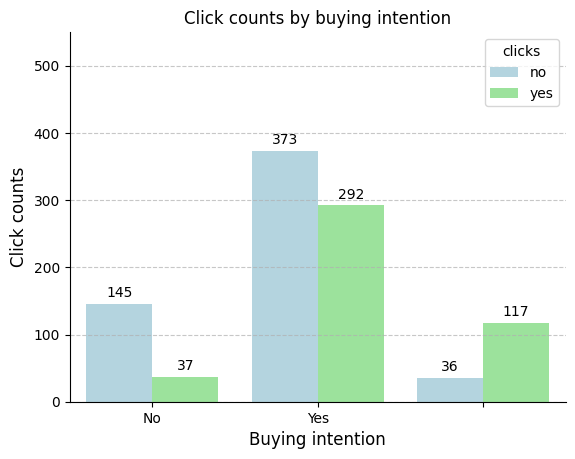

In [286]:
ax= sns.countplot(data=dummy_vars, x="buying_intention", hue= "click", palette=['lightblue', 'lightgreen'])
ax.set_xlabel("Buying intention", fontsize= 12)
ax.set_ylabel("Click counts", fontsize= 12)
ax.spines[["right","top"]].set_visible(False)
ax.yaxis.grid(True, linestyle= "--", alpha= 0.7)
ax.set_ylim(0,550)
#ax.set_xticks([0, 1])
ax.set_xticklabels(["No", "Yes"])

for container in ax.containers:
    vals = container.datavalues  # these are the bar heights
    labels = [f"{int(v)}" if v > 0 else "" for v in vals]  # hide 0s
    ax.bar_label(container, labels=labels, label_type="edge", padding=3, fontsize=10)
    
plt.title("Click counts by buying intention")
plt.legend(labels=["no", "yes"], title= "clicks")
plt.show()
